# Data Practicum II - Used Car Cleaning

In [8]:
import pandas as pd
import numpy as np
import random as rnd
import math 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error #Get RMSE to return units to original to compare can find this by simply rotting the MSE

In [9]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Cleaning/Preprocessing

In [10]:
#Reformat Output to avoid scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [11]:
workingDataset = pd.read_csv("vehicles.csv")

In [12]:
workingDataset.shape

(426880, 26)

Before even inspecting the dataset further what we want to do is remove any duplicates. 

In [13]:
workingDataset = workingDataset.drop_duplicates()

In [14]:
workingDataset.shape

(426880, 26)

Now we want to remove any irrelevant data. The end goal of this project is to come out with a model to predict used car prices. 

In [15]:
workingDataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

Looking over the summary we can see that we have a lot of string types that will need to be cleaned but even before that we have a lot of missing values. County has zero entries so removing that can be done without question. Additional attributes that we don't really need are posting_data, image_url, id, url, region_url, description, and VIN. The one complex issue I see is using region, state, lat, and long. I should pick either between region and state or lat and long. Using the categorical attributes my dataset would become very large and sparce. I will go ahead and use lat and long to make the data dimensions more managable. 

In [16]:
print(workingDataset.shape)
workingDataset = workingDataset.drop(['id','url','region','region_url','VIN','image_url','description','county','state','posting_date'], axis=1)
print(workingDataset.shape)

(426880, 26)
(426880, 16)


In [17]:
workingDataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  lat           420331 non-null  float64
 15  long          420331 non-null  float64
dtypes: float64(4), int64(1), object(11)
memory usage: 55.4+ MB


Lets look at the percentage of missing values

In [18]:
workingDataset.isna().mean().sort_values(ascending=False)

size           0.72
cylinders      0.42
condition      0.41
drive          0.31
paint_color    0.31
type           0.22
manufacturer   0.04
title_status   0.02
long           0.02
lat            0.02
model          0.01
odometer       0.01
fuel           0.01
transmission   0.01
year           0.00
price          0.00
dtype: float64

In [19]:
workingDataset.isna().sum().sort_values(ascending=False)

size            306361
cylinders       177678
condition       174104
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
long              6549
lat               6549
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
price                0
dtype: int64

Looking at the percentage of missing data we don't really need size. We have type which is essetially a more broader category and has significantly less missing values to work with. 

In [20]:
print(workingDataset.shape)
workingDataset = workingDataset.drop(['size'], axis=1)
print(workingDataset.shape)

(426880, 16)
(426880, 15)


What has to be done before we can fill missing values with the iterative imputer i want to use is we need to convert categorical attributes to numeric. I also need to convert all empty spaces to NaN

In [21]:
workingDataset.replace(r'^\s+$', np.nan, regex=True)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,lat,long
0,6000,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,nan,nan
1,11900,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,nan,nan
2,21000,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,nan,nan
3,1500,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,nan,nan
4,4900,nan,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.00,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.00,clean,other,fwd,sedan,NaN,33.79,-84.45
426876,30590,2020.00,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.00,clean,other,fwd,sedan,red,33.79,-84.45
426877,34990,2020.00,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.00,clean,other,NaN,hatchback,white,33.78,-84.41
426878,28990,2018.00,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.00,clean,other,fwd,sedan,silver,33.79,-84.45


In [22]:
workingDataset.describe(include='all')

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,lat,long
count,426880.00,425675.00,409234,421603,252776,249202,423867,422480.00,418638,424324,296313,334022,296677,420331.00,420331.00
unique,nan,nan,42,29667,6,8,5,nan,6,3,3,13,12,nan,nan
top,nan,nan,ford,f-150,good,6 cylinders,gas,nan,clean,automatic,4wd,sedan,white,nan,nan
freq,nan,nan,70985,8009,121456,94169,356209,nan,405117,336524,131904,87056,79285,nan,nan
mean,75199.03,2011.24,NaN,NaN,NaN,NaN,NaN,98043.33,NaN,NaN,NaN,NaN,NaN,38.49,-94.75
std,12182282.17,9.45,NaN,NaN,NaN,NaN,NaN,213881.50,NaN,NaN,NaN,NaN,NaN,5.84,18.37
min,0.00,1900.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,-84.12,-159.83
25%,5900.00,2008.00,NaN,NaN,NaN,NaN,NaN,37704.00,NaN,NaN,NaN,NaN,NaN,34.60,-111.94
50%,13950.00,2013.00,NaN,NaN,NaN,NaN,NaN,85548.00,NaN,NaN,NaN,NaN,NaN,39.15,-88.43
75%,26485.75,2017.00,NaN,NaN,NaN,NaN,NaN,133542.50,NaN,NaN,NaN,NaN,NaN,42.40,-80.83


Model has almost 30,000 unique values which makes it very hard to use in actual model training. For now I will remove it but come back to it and perhaps clean is up if possible to reduce the number of categories. Truth be told I don't believe model to be that useful after all because I have type, drive, cylinders, and manufacturer. The same goes for the color of the car. Having been on craigslist usually cars that are marked as zero are not actually free or anything so to avoid bias and misinformation I am going to remove all cars with a zero price tag. 

In [23]:
print(workingDataset.shape)
workingDataset = workingDataset.drop(['model','paint_color'], axis=1)
print(workingDataset.shape)

(426880, 15)
(426880, 13)


In [24]:
workingDataset = workingDataset[(workingDataset['price'] != 0)]

In [25]:
workingDataset.shape

(393985, 13)

#### Get rid of rows with more than half of its attributes missing

In [26]:
#Only keep rows that have at least 10 of the 13 possible attributes
print(workingDataset.shape)
workingDataset = workingDataset.dropna(thresh=10)
print(workingDataset.shape)

(393985, 13)
(349406, 13)


In [27]:
workingDataset.isna().mean().sort_values(ascending=False)

cylinders      0.33
condition      0.31
drive          0.22
type           0.12
manufacturer   0.03
title_status   0.02
long           0.01
lat            0.01
odometer       0.01
fuel           0.00
transmission   0.00
year           0.00
price          0.00
dtype: float64

In [28]:
workingDataset.isna().sum().sort_values(ascending=False)

cylinders       116686
condition       107905
drive            76914
type             43629
manufacturer     11170
title_status      6480
long              2927
lat               2927
odometer          1760
fuel              1334
transmission       967
year               545
price                0
dtype: int64

### Ordinal Encoding

In [29]:
#Doesn't do anything to NaN's (COnvert to categorical then impute then convert back.)
cleanup_nums = {"condition": {"salvage": 1, "fair": 2,"good": 3, "like new": 4, "excellent": 5, "new": 6},
               "cylinders": {"other": 1, "3 cylinders": 2,"4 cylinders": 3, "5 cylinders": 4, "6 cylinders": 5, "8 cylinders": 6,"10 cylinders": 7, "12 cylinders": 8}}
imputing_nums = {"manufacturer": {"gmc": 1, "chevrolet": 2,"toyota": 3, "ford": 4, "jeep": 5, "nissan": 6, "ram": 7,"mazda": 8, "cadillac": 9, "honda": 10, "dodge":11, "lexus": 12, "jaguar": 13, "buick": 14, "chrysler": 15, "volvo": 16, "audi": 17, "infiniti": 18, "lincoln": 19, "alfa-romeo": 20, "subaru": 21, "acura": 22, "hyundai": 23,"mercedes-benz": 24, "bmw": 25, "mitsubishi": 26, "volkswagen": 27, "porsche":28, "kia": 29, "rover": 30, "ferrari": 31, "mini": 32, "pontiac": 33, "fiat": 34, "tesla": 35, "saturn": 36, "mercury": 37, "harley-davidson": 38, "datsun": 39, "aston-martin": 40, "land rover":41, "morgan": 42},
                "fuel": {"gas": 1, "other": 2,"diesel": 3, "hybrid": 4, "electric": 5},
                "title_status": {"clean":1, "rebuilt":2, "salvage":3, "lien":4, "missing":5, "parts only": 6},
                "transmission": {"automatic": 1, "other": 2,"manual": 3},
                "drive": {"4wd": 1, "fwd": 2,"rwd": 3},
                "type": {"sedan": 1, "SUV": 2,"pickup": 3, "truck": 4, "other": 5, "coupe": 6, "hatchback": 7,"wagon": 8, "van": 9, "convertible": 10, "mini-van":11, "offroad": 12, "bus": 13}}

In [30]:
workingDataset = workingDataset.replace(cleanup_nums)

In [31]:
workingDataset = workingDataset.replace(imputing_nums)

In [32]:
workingDataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349406 entries, 27 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         349406 non-null  int64  
 1   year          348861 non-null  float64
 2   manufacturer  338236 non-null  float64
 3   condition     241501 non-null  float64
 4   cylinders     232720 non-null  float64
 5   fuel          348072 non-null  float64
 6   odometer      347646 non-null  float64
 7   title_status  342926 non-null  float64
 8   transmission  348439 non-null  float64
 9   drive         272492 non-null  float64
 10  type          305777 non-null  float64
 11  lat           346479 non-null  float64
 12  long          346479 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 37.3 MB


### Imputing missing values with iterative imputer

In [33]:
imp_mode = IterativeImputer(initial_strategy = 'most_frequent',random_state=0, min_value = [0,1900,1,1,1,1,0,1,1,1,1,-84.12,-159.83], max_value = [30000000,2022,42,6,8,5,10000000,6,3,3,13,82.25,173.89])

In [34]:
imputedData = pd.DataFrame(imp_mode.fit_transform(workingDataset),columns = workingDataset.columns)

In [35]:
imputedData = imputedData.round({'price': 0, 'year': 0, 'manufacturer': 0, 'condition': 0, 'cylinders': 0, 'fuel': 0, 'odometer': 0, 'title_status': 0, 'transmission': 0, 'drive': 0, 'type': 0, 'lat': 2, 'long': 2})

In [36]:
imputedData.isna().mean().sort_values(ascending=False)

long           0.00
lat            0.00
type           0.00
drive          0.00
transmission   0.00
title_status   0.00
odometer       0.00
fuel           0.00
cylinders      0.00
condition      0.00
manufacturer   0.00
year           0.00
price          0.00
dtype: float64

In [37]:
imputedData.isna().sum().sort_values(ascending=False)

long            0
lat             0
type            0
drive           0
transmission    0
title_status    0
odometer        0
fuel            0
cylinders       0
condition       0
manufacturer    0
year            0
price           0
dtype: int64

In [38]:
imputedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349406 entries, 0 to 349405
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         349406 non-null  float64
 1   year          349406 non-null  float64
 2   manufacturer  349406 non-null  float64
 3   condition     349406 non-null  float64
 4   cylinders     349406 non-null  float64
 5   fuel          349406 non-null  float64
 6   odometer      349406 non-null  float64
 7   title_status  349406 non-null  float64
 8   transmission  349406 non-null  float64
 9   drive         349406 non-null  float64
 10  type          349406 non-null  float64
 11  lat           349406 non-null  float64
 12  long          349406 non-null  float64
dtypes: float64(13)
memory usage: 34.7 MB


In [39]:
imputedData.describe()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,lat,long
count,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00
mean,65786.62,2011.35,10.40,3.88,4.64,1.26,94594.88,1.06,1.29,1.80,3.49,38.55,-94.72
std,11101686.46,9.17,9.04,0.85,1.05,0.66,172855.16,0.35,0.57,0.69,2.48,5.85,18.31
min,1.00,1900.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,-84.12,-159.83
25%,7770.00,2008.00,4.00,3.00,4.00,1.00,36415.50,1.00,1.00,1.00,2.00,34.74,-111.93
50%,15990.00,2014.00,6.00,4.00,5.00,1.00,83957.00,1.00,1.00,2.00,3.00,39.17,-88.26
75%,27990.00,2017.00,17.00,5.00,5.00,1.00,132000.00,1.00,1.00,2.00,5.00,42.36,-80.98
max,3736928711.00,2022.00,42.00,6.00,8.00,5.00,10000000.00,6.00,3.00,3.00,13.00,82.25,173.89


In [40]:
#Convert price to original data type
convert_dict = {'price': float,
                'year': int,
                'manufacturer': int,
                'condition' : int,
                'cylinders' : int,
                'fuel': int,
                'odometer': int,
                'title_status' : int,
                'transmission' : int,
                'drive' : int,
                'type' : int,
                'lat' : float,
                'long' : float}  
  
imputedData = imputedData.astype(convert_dict)  

In [41]:
imputedData.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,lat,long
0,33590.00,2014,1,3,6,1,57923,1,2,2,3,32.59,-85.48
1,22590.00,2010,2,3,6,1,71229,1,2,2,3,32.59,-85.48
2,39590.00,2020,2,3,6,1,19160,1,2,2,3,32.59,-85.48
3,30990.00,2017,3,3,6,1,41124,1,2,2,3,32.59,-85.48
4,15000.00,2013,4,5,5,1,128000,1,1,3,4,32.59,-85.52


In [42]:
imputing_nums_reverse = {"manufacturer": {1:"gmc" , 2:"chevrolet" , 3:"toyota" , 4:"ford" , 5:"jeep" , 6:"nissan" , 7:"ram" , 8:"mazda" , 9:"cadillac" , 10:"honda" , 11:"dodge" , 12:"lexus" , 13:"jaguar" , 14:"buick" , 15:"chrysler" , 16:"volvo" , 17:"audi" , 18:"infiniti" , 19:"lincoln" , 20:"alfa-romeo" , 21:"subaru" , 22:"acura" , 23:"hyundai" , 24:"mercedes-benz" , 25:"bmw" , 26:"mitsubishi" , 27:"volkswagen" , 28:"porsche" , 29:"kia" , 30:"rover" , 31:"ferrari" , 32:"mini" , 33:"pontiac" , 34:"fiat" , 35:"tesla" , 36:"saturn" , 37:"mercury" , 38:"harley-davidson" , 39:"datsun" , 40:"aston-martin" , 41:"land rover" , 42:"morgan"},
                "fuel": {1:"gas" , 2:"other" , 3:"diesel" , 4:"hybrid" , 5:"electric"},
                "title_status": {1:"clean" , 2:"rebuilt" , 3:"salvage" , 4:"lien" , 5:"missing" , 6:"parts only"},
                "transmission": {1:"automatic" , 2:"other" , 3:"manual"},
                "drive": {1:"4wd" , 2:"fwd" , 3:"rwd"},
                "type": {1:"sedan" , 2:"SUV" , 3:"pickup" , 4:"truck" , 5:"other" , 6:"coupe" , 7:"hatchback" , 8:"wagon" , 9:"van" , 10:"convertible" , 11:"mini-van", 12:"offroad" , 13:"bus"}}

In [43]:
imputedData = imputedData.replace(imputing_nums_reverse)

### One Hot Encoding

In [44]:
imputedData = pd.get_dummies(imputedData, columns=['manufacturer','fuel','title_status','transmission','drive','type'], prefix=['manufacturer','fuel','title_status','transmission','drive','type'])

### Cont. Cleaning

In [45]:
imputedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349406 entries, 0 to 349405
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   price                         349406 non-null  float64
 1   year                          349406 non-null  int32  
 2   condition                     349406 non-null  int32  
 3   cylinders                     349406 non-null  int32  
 4   odometer                      349406 non-null  int32  
 5   lat                           349406 non-null  float64
 6   long                          349406 non-null  float64
 7   manufacturer_acura            349406 non-null  uint8  
 8   manufacturer_alfa-romeo       349406 non-null  uint8  
 9   manufacturer_aston-martin     349406 non-null  uint8  
 10  manufacturer_audi             349406 non-null  uint8  
 11  manufacturer_bmw              349406 non-null  uint8  
 12  manufacturer_buick            349406 non-nul

In [46]:
imputedData.shape

(349406, 79)

In [47]:
imputedData.head(5)

,price,year,condition,cylinders,odometer,lat,long,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,33590.00,2014,3,6,57923,32.59,-85.48,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,22590.00,2010,3,6,71229,32.59,-85.48,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,39590.00,2020,3,6,19160,32.59,-85.48,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,30990.00,2017,3,6,41124,32.59,-85.48,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,15000.00,2013,5,5,128000,32.59,-85.52,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [48]:
imputedData.describe()

,price,year,condition,cylinders,odometer,lat,long,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
count,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,...,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00,349406.00
mean,65786.62,2011.35,3.88,4.64,94594.88,38.55,-94.72,0.02,0.00,0.00,...,0.05,0.05,0.01,0.00,0.06,0.19,0.23,0.12,0.02,0.03
std,11101686.46,9.17,0.85,1.05,172855.16,5.85,18.31,0.12,0.05,0.01,...,0.22,0.21,0.11,0.04,0.24,0.40,0.42,0.33,0.15,0.17
min,1.00,1900.00,1.00,1.00,0.00,-84.12,-159.83,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7770.00,2008.00,3.00,4.00,36415.50,34.74,-111.93,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,15990.00,2014.00,4.00,5.00,83957.00,39.17,-88.26,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,27990.00,2017.00,5.00,5.00,132000.00,42.36,-80.98,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,3736928711.00,2022.00,6.00,8.00,10000000.00,82.25,173.89,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Removing Outliers for Continous Features

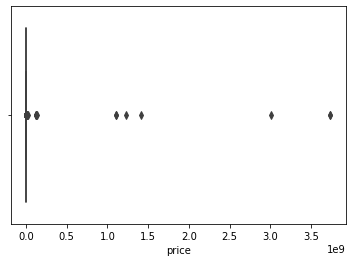

In [49]:
_ = sns.boxplot(x="price", data=imputedData)

As you can see the prices are so extreme in some cases that you can't even see the boxplot interior. 

In [50]:
Q1= imputedData['price'].quantile(0.25)
Q3 = imputedData['price'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR
print("Lower Whisker: ", lower_limit)
print("Upper whisker: ", upper_limit)

Lower Whisker:  -22560.0
Upper whisker:  58320.0


In [51]:
len(imputedData[imputedData['price'] >= 58320])

7034

In [52]:
modelingDataset = imputedData[(imputedData['price'] < upper_limit)]

In [53]:
modelingDataset.shape

(342372, 79)

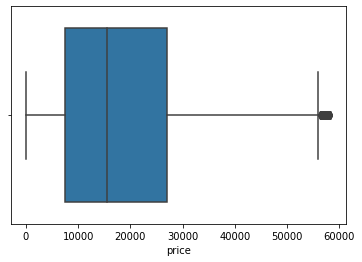

In [54]:
_ = sns.boxplot(x="price", data=modelingDataset)

In [55]:
Q1= modelingDataset['price'].quantile(0.25)
Q3 = modelingDataset['price'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR
print("Lower Whisker: ", lower_limit)
print("Upper whisker: ", upper_limit)

Lower Whisker:  -21742.5
Upper whisker:  56237.5


In [56]:
len(modelingDataset[modelingDataset['price'] >= 56237])

826

In [57]:
modelingDataset = modelingDataset[(modelingDataset['price'] < upper_limit)]

In [58]:
modelingDataset.shape

(341546, 79)

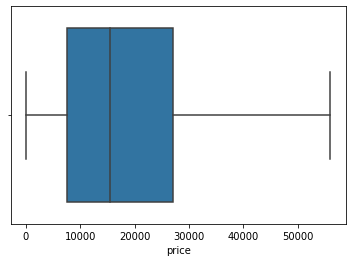

In [59]:
_ = sns.boxplot(x="price", data=modelingDataset)

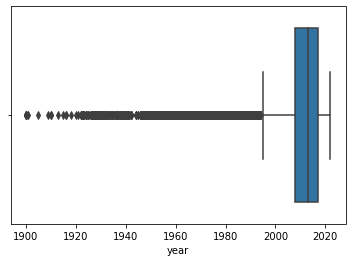

In [60]:
_ = sns.boxplot(x="year", data=modelingDataset)

In [61]:
Q1= modelingDataset['year'].quantile(0.25)
Q3 = modelingDataset['year'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR
print("Lower Whisker: ", lower_limit)
print("Upper whisker: ", upper_limit)

Lower Whisker:  1994.5
Upper whisker:  2030.5


In [62]:
len(modelingDataset[modelingDataset['year'] <= 1994])

12061

In [63]:
modelingDataset = modelingDataset[(modelingDataset['year'] > 1994)]

In [64]:
modelingDataset.shape

(329485, 79)

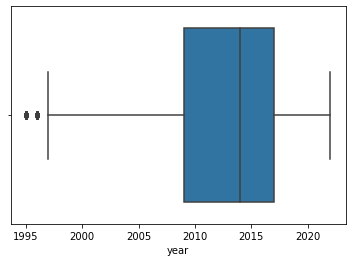

In [65]:
_ = sns.boxplot(x="year", data=modelingDataset)

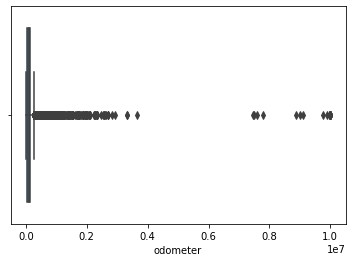

In [66]:
_ = sns.boxplot(x="odometer", data=modelingDataset)

In [67]:
Q1= modelingDataset['odometer'].quantile(0.25)
Q3 = modelingDataset['odometer'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR
print("Lower Whisker: ", lower_limit)
print("Upper whisker: ", upper_limit)

Lower Whisker:  -105067.0
Upper whisker:  276717.0


In [68]:
len(modelingDataset[modelingDataset['odometer'] >= 276717])

2651

In [69]:
modelingDataset = modelingDataset[(modelingDataset['odometer'] < 276717)]

In [70]:
modelingDataset.shape

(326834, 79)

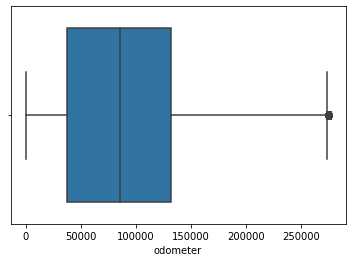

In [71]:
_ = sns.boxplot(x="odometer", data=modelingDataset)

In [72]:
modelingDataset.to_csv('modelingDataset.csv')

<h2><center>End of Data Cleaning</center></h2>